# 21. RNN with Bitcoin Price

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data

import random
import numpy as np
import pandas as pd

import sklearn.metrics as metrics

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 21.1 Prepare Data

In [3]:
raw_data = pd.read_csv('data/bitcoin_data.csv')
raw_data.head()

,date,price
0,2013-01-02 0:00,13.40000
1,2013-01-04 0:00,13.48986
2,2013-01-06 0:00,13.52999
3,2013-01-08 0:00,13.83000
4,2013-01-10 0:00,14.32000


In [4]:
len(raw_data)

906

In [5]:
sample_data = raw_data[500:510]
sample_data

,date,price
500,2015-09-29 0:00,237.68
501,2015-10-01 0:00,238.98
502,2015-10-03 0:00,239.17
503,2015-10-05 0:00,239.22
504,2015-10-07 0:00,245.25
505,2015-10-09 0:00,244.78
506,2015-10-11 0:00,248.08
507,2015-10-13 0:00,249.58
508,2015-10-15 0:00,254.73
509,2015-10-17 0:00,269.07


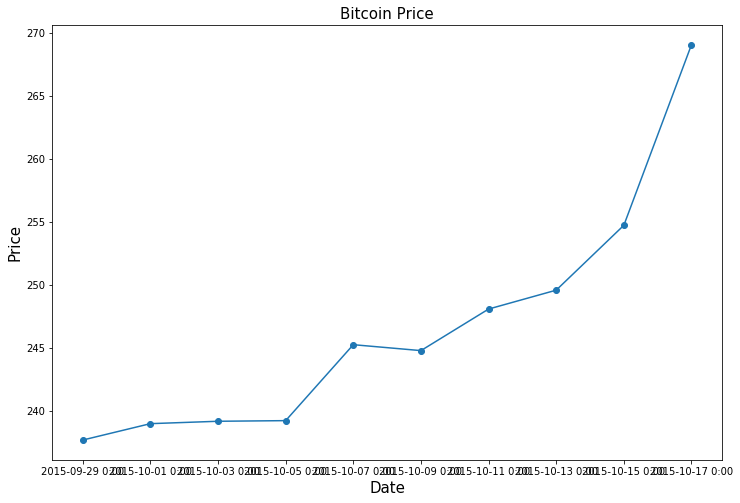

In [6]:
plt.figure(figsize=(12, 8))
plt.plot(sample_data['date'],sample_data['price'],'o-')
plt.title("Bitcoin Price", fontdict={'size':15})
plt.xlabel('Date', fontdict={'size':15})
plt.ylabel('Price', fontdict={'size':15})
plt.show()

In [7]:
train_data = raw_data['price'][:800]
test_data = raw_data['price'][800:]

## 21.2 Define Model

In [8]:
# Parameters:	
# input_size – The number of expected features in the input x
# hidden_size – The number of features in the hidden state h
# num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two RNNs together to form a stacked RNN, with the second RNN taking in outputs of the first RNN and computing the final results. Default: 1
# nonlinearity – The non-linearity to use. Can be either ‘tanh’ or ‘relu’. Default: ‘tanh’
# bias – If False, then the layer does not use bias weights b_ih and b_hh. Default: True
# batch_first – If True, then the input and output tensors are provided as (batch, seq, feature). Default: False
# dropout – If non-zero, introduces a Dropout layer on the outputs of each RNN layer except the last layer, with dropout probability equal to dropout. Default: 0
# bidirectional – If True, becomes a bidirectional RNN. Default: False

In [9]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        #self.rnn = nn.GRU(input_size, hidden_size, num_layers)
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, nonlinearity='relu', batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden) :
        # input of shape (batch, seq_len, input_size)
        # output of shape (batch, seq_len, hidden_size)
        out, hidden = self.rnn(input, hidden)
        
        # fc_output of shape (batch, seq_len, output_size)
        fc_out = self.fc(out)
        return fc_out, hidden

    def init_hidden(self, batch_size):
        # h of shape (num_layers, batch, hidden_size)
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).cuda()
        return hidden

In [10]:
seq_len = 10
num_layers = 2

In [11]:
model = RNN(1, 32, 1, num_layers).cuda()

## 21.3 Data Preprocessing

In [12]:
x = train_data[0 : seq_len].values
y = train_data[1 : seq_len+1].values
for sp in range(1, len(train_data) - seq_len) :
    x = np.vstack((x, train_data[sp : sp+seq_len].values))
    y = np.vstack((y, train_data[sp + 1 : sp+seq_len + 1].values))

In [13]:
x = torch.from_numpy(x).type(torch.FloatTensor)
y = torch.from_numpy(y).type(torch.FloatTensor)

In [14]:
train_data = Data.TensorDataset(x, y)

batch_size = 10

train_loader = Data.DataLoader(dataset=train_data,
                              batch_size=batch_size,
                              shuffle=True,
                              drop_last = True)

## 21.4 Train Model

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = nn.MSELoss()

In [16]:
num_epochs = 10

In [17]:
for epoch in range(num_epochs):
    
    total_batch = len(train_data) // batch_size
    
    for i, (batch_values, batch_labels) in enumerate(train_loader):
        
        hidden = model.init_hidden(batch_size)
        
        X = batch_values.view(-1, seq_len, 1).cuda()
        Y = batch_labels.view(-1, seq_len, 1).cuda()
        
        pre, hidden = model(X, hidden)
        cost = loss(pre, Y)
        
        optimizer.zero_grad()
        cost.backward()
        
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        
        optimizer.step()
        
        if (i+1) % 20 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))
    
print("Learning Finished!")

Epoch [1/10], lter [20/79], Loss: 250887.0938
Epoch [1/10], lter [40/79], Loss: 57354.2969
Epoch [1/10], lter [60/79], Loss: 66762.8516
Epoch [2/10], lter [20/79], Loss: 12747.3311
Epoch [2/10], lter [40/79], Loss: 16353.3926
Epoch [2/10], lter [60/79], Loss: 2941.0237
Epoch [3/10], lter [20/79], Loss: 1433.3604
Epoch [3/10], lter [40/79], Loss: 1941.4967
Epoch [3/10], lter [60/79], Loss: 1441.0657
Epoch [4/10], lter [20/79], Loss: 673.7904
Epoch [4/10], lter [40/79], Loss: 5105.0664
Epoch [4/10], lter [60/79], Loss: 1341.3879
Epoch [5/10], lter [20/79], Loss: 2462.6973
Epoch [5/10], lter [40/79], Loss: 803.0812
Epoch [5/10], lter [60/79], Loss: 1449.7054
Epoch [6/10], lter [20/79], Loss: 3300.7988
Epoch [6/10], lter [40/79], Loss: 743.8008
Epoch [6/10], lter [60/79], Loss: 2485.7949
Epoch [7/10], lter [20/79], Loss: 538.6587
Epoch [7/10], lter [40/79], Loss: 1405.6044
Epoch [7/10], lter [60/79], Loss: 228.5135
Epoch [8/10], lter [20/79], Loss: 546.1379
Epoch [8/10], lter [40/79], Loss

## 21.5 Test Model

In [18]:
model.eval()

hidden = model.init_hidden(1)

X = torch.from_numpy(test_data[0:seq_len].values).type(torch.FloatTensor).cuda().view(1, seq_len, 1)
y, hidden = model(X, hidden)

In [19]:
data = test_data[1:seq_len].values
pre = y.reshape(-1)[0:-1]
pre = pre.cpu().data.numpy()

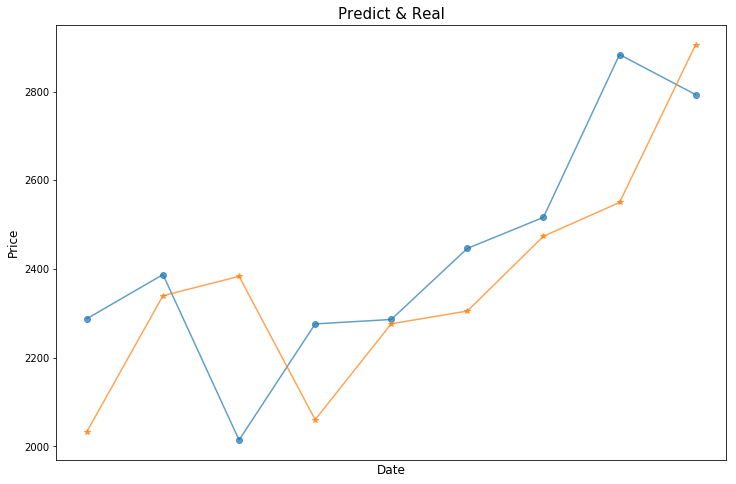

In [20]:
plt.figure(figsize=(12, 8))

plt.plot(raw_data['date'][801:801+seq_len-1], data,'o-', alpha=0.7)
plt.plot(raw_data['date'][801:801+seq_len-1], pre, '*-', alpha=0.7)

plt.title("Predict & Real", fontdict={'size':15})

plt.xlabel('Date', fontdict={'size':12})
plt.xticks([])

plt.ylabel('Price', fontdict={'size':12})


plt.show()